# Basemap creation

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [2]:
%matplotlib inline

# Teapot Dome Maps and Figures

In [3]:
%%capture
wells = pd.read_csv('../Munging/TeapotDomeWellHeaders.csv')
gdf = gpd.GeoDataFrame(wells, geometry=gpd.points_from_xy(wells.Easting, wells.Northing))
gdf.crs = {'init':'EPSG:32056'}
reproj = gdf.to_crs({'init':'EPSG:4324'})

Read in all the spatial basemap data

In [4]:
%%capture
cities = gpd.read_file('../base_data/cities.shp')
cities = cities.to_crs("EPSG:4324")
cities = cities[cities.Population>15000]
state = gpd.read_file('../base_data/States.shp')
state = state.to_crs("EPSG:4324")
highway = gpd.read_file('../base_data/Highway_road.shp')
highway = highway.to_crs("EPSG:4324")
counties = gpd.read_file('../base_data/County_boundaries_polys.shp')
counties = counties.to_crs("EPSG:4324")
basins = gpd.read_file('../base_data/Basins.shp')
basins = basins.to_crs("EPSG:4324")
basins.iloc[1,1] = 'GREATER GREEN RIVER BASIN'
basins.iloc[5,1] = 'DENVER BASIN'
basins = basins[basins.BASIN_NAME.isin(['POWDER RIVER BASIN', 'LARAMIE BASIN', 'HANNA BASIN', 'SHIRLEY BASIN', 'WIND RIVER BASIN',
                              'BIGHORN BASIN', 'GREATER GREEN RIVER BASIN', 'DENVER BASIN'])]
state = state[state.STATE_NAME.isin(['Wyoming', 'Colorado', 'Montana', 'Idaho', 'Nebraska', 'South Dakota', 'Utah'])]
highway = highway[highway['TYPE'] == 'Interstate']

Plot the basemaps

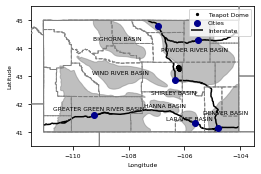

In [5]:
fig, ax = plt.subplots(1,1, figsize=(4,4))
reproj.plot(color='k', ax=ax, label='Teapot Dome', markersize=5, zorder=2)
cities.plot(color='darkblue', ax=ax, label='Cities', zorder=4)
state.plot(edgecolor='gray',color='None', ax=ax, zorder=3)
highway.plot(color='black', ax=ax, label='Interstate', zorder=3)
counties.plot(color='None', edgecolor='gray', ax=ax, linestyle='--', zorder=3)
basins.plot(color='gray', edgecolor='gray', ax=ax, linestyle='-', alpha=0.5, zorder=1)
#ax = basins.plot()
basins.apply(lambda x: ax.annotate(s=x.BASIN_NAME, xy=x.geometry.centroid.coords[0], ha='center', fontsize=6),axis=1)
plt.xlim( -111.5, -103.5)
plt.ylim(40.5, 45.5)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.xlabel('Longitude', fontsize=6)
plt.ylabel('Latitude', fontsize=6)
plt.legend(fontsize=6)
#plt.savefig('basemap.pdf')

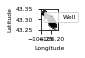

In [6]:
fig, ax = plt.subplots(1,1, figsize=(1,2))
reproj.plot(color='k', ax=ax, markersize=0.5, label='Well', edgecolor='None')

plt.xlabel('Longitude', fontsize=6)
plt.ylabel('Latitude', fontsize=6)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.xlim( -106.25, -106.17)
plt.ylim(43.25, 43.35) 
plt.legend(fontsize=6)
#plt.savefig('base_close.pdf')
plt.tight_layout()

Now read in the error data by well and plot it up

In [7]:
%%capture
by_wellDF = pd.read_csv('../01_teapot_rec_sys/error_map.csv', index_col=[0])
gdf = gpd.GeoDataFrame(by_wellDF, geometry=gpd.points_from_xy(by_wellDF.Easting, by_wellDF.Northing))
gdf.crs = {'init':'EPSG:32056'}
errors = gdf.to_crs({'init':'EPSG:4324'})
tops = pd.read_csv("../01_teapot_rec_sys/teapot_clean.csv", index_col=[0]) #read in the top data
picksvsmae = pd.merge(errors, pd.DataFrame(tops.API.value_counts().reset_index().rename(columns={'index':'API', 'API':'n_picks'}))
         , on='API')
errors['Longitude'] = errors.geometry.x
errors['Latitude'] = errors.geometry.y

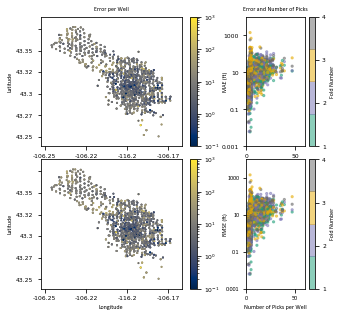

In [8]:
grid = plt.GridSpec(2, 3, wspace=0.4, hspace=0.1)
fig = plt.figure(figsize=(5, 5))

ul = plt.subplot(grid[0, :2])
u1 = ul.scatter(errors.Longitude, errors.Latitude, c=errors.Well_MAE, 
            norm=colors.LogNorm(vmin=0.1, vmax=10**3),
          cmap='cividis', s=1)
ul.set_ylabel('Latitude', fontsize=6, fontname='Calibri')
ul.set_xticklabels([-106.27, -106.25,-106.22, -116.2, -106.17],fontsize=6)
ul.set_yticklabels([43.22,43.25,43.27,43.3,43.32,43.35],fontsize=6)
ul.set_title('Error per Well', fontsize=6, fontname='Calibri')
ulcb = fig.colorbar(u1)
ulcb.set_label('MAE (ft)', fontsize=6, fontname='Calibri')
ulcb.ax.tick_params(labelsize=6)

ur = plt.subplot(grid[0, 2:])
u2 = ur.scatter(picksvsmae.n_picks, picksvsmae.Well_MAE, c=picksvsmae.foldno, cmap=plt.cm.get_cmap('Dark2', 4)
            , alpha=0.5, s=5)
ur.semilogy()
ur.set_ylim(0.001, 10000)
ur.set_xlim(0,60)
ur.set_xticklabels([0,50],fontsize=6)
ur.set_yticklabels([10^-4,10**-3, 10**-1, 10**1, 10**3],fontsize=6)
uppercb = fig.colorbar(u2,ticks=range(4) )
uppercb.set_label('Fold Number', fontsize=6, fontname='Calibri')
uppercb.set_ticklabels([1,2,3,4])
uppercb.ax.tick_params(labelsize=6)
ur.set_title('Error and Number of Picks', fontsize=6, fontname='Calibri')

ll = plt.subplot(grid[1, :2])
l1 = ll.scatter(errors.Longitude, errors.Latitude, c=errors.well_rmse, 
            norm=colors.LogNorm(vmin=0.1, vmax=10**3),
          cmap='cividis', s=1)
ll.set_xlabel('Longitude', fontsize=6, fontname='Calibri')
ll.set_ylabel('Latitude', fontsize=6, fontname='Calibri')
ll.set_xticklabels([-106.27, -106.25,-106.22, -116.2, -106.17],fontsize=6)
ll.set_yticklabels([43.22,43.25,43.27,43.3,43.32,43.35],fontsize=6)
llcb = fig.colorbar(u1)
llcb.set_label('RMSE (ft)', fontsize=6, fontname='Calibri')
llcb.ax.tick_params(labelsize=6)

lr = plt.subplot(grid[1, 2]);
l2 = lr.scatter(picksvsmae.n_picks, picksvsmae.well_rmse, c=picksvsmae.foldno, cmap=plt.cm.get_cmap('Dark2', 4)
            , alpha=0.5, s=5)
lr.semilogy()
lr.set_ylim(0.001, 10000)
lr.set_xlim(0,60)
lr.set_xlabel('Number of Picks per Well', fontsize=6, fontname='Calibri')
lr.set_xticklabels([0,50],fontsize=6, fontname='Calibri')
lr.set_yticklabels([10^-4,10**-3, 10**-1, 10**1, 10**3],fontsize=6, fontname='Calibri')
lowercb = fig.colorbar(u2,ticks=range(4) )
lowercb.set_label('Fold Number', fontsize=6, fontname='Calibri')
lowercb.set_ticklabels([1,2,3,4])
lowercb.ax.tick_params(labelsize=6)

#plt.savefig('teapot_map.svg')

# Mannville maps

In [9]:
by_wellDF = pd.read_csv('mann_error_map.csv', index_col=[0])
tops = pd.read_csv(r"../02_mannville_rec_sys/mannville_cleaned.csv", index_col=[0]) #read in the top data


In [10]:
picksvsmae = pd.merge(by_wellDF, pd.DataFrame(tops.SitID.value_counts().reset_index().rename(columns={'index':'SitID', 'SitID':'n_picks'}))
         , on='SitID')

In [11]:
grid = plt.GridSpec(2, 3, wspace=0.4, hspace=0.1)

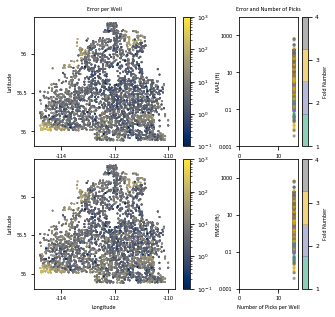

In [12]:
fig = plt.figure(figsize=(5, 5))

ul = plt.subplot(grid[0, :2])
u1 = ul.scatter(by_wellDF.Longitude, by_wellDF.Latitude, c=by_wellDF.Well_MAE, 
            norm=colors.LogNorm(vmin=0.1, vmax=10**3),
          cmap='cividis', s=1)
ul.set_ylabel('Latitude', fontsize=6, fontname='Calibri')
ul.set_xticklabels([-116,-114,-112,-110],fontsize=6, fontname='Calibri')
ul.set_yticklabels([54.5,55,55.5,56,56.5,57,57.5],fontsize=6, fontname='Calibri')
ul.set_title('Error per Well', fontsize=6, fontname='Calibri')
ulcb = fig.colorbar(u1)
ulcb.set_label('MAE (ft)', fontsize=6, fontname='Calibri')
ulcb.ax.tick_params(labelsize=6)

ur = plt.subplot(grid[0, 2])
u2 = ur.scatter(picksvsmae.n_picks, picksvsmae.Well_MAE, c=picksvsmae.foldno, cmap=plt.cm.get_cmap('Dark2', 4)
            , alpha=0.5, s=5)
ur.semilogy()
ur.set_ylim(0.001, 10000)
ur.set_xlim(0,15)
ur.set_xticklabels([0,10],fontsize=6, fontname='Calibri')
ur.set_yticklabels([10^-4,10**-3, 10**-1, 10**1, 10**3],fontsize=6, fontname='Calibri')
uppercb = fig.colorbar(u2,ticks=range(4) )
uppercb.set_label('Fold Number', fontsize=6, fontname='Calibri')
uppercb.set_ticklabels([1,2,3,4])
uppercb.ax.tick_params(labelsize=6)
ur.set_title('Error and Number of Picks', fontsize=6, fontname='Calibri')

ll = plt.subplot(grid[1, :2])
l1 = ll.scatter(by_wellDF.Longitude, by_wellDF.Latitude, c=by_wellDF.well_rmse, 
            norm=colors.LogNorm(vmin=0.1, vmax=10**3),
          cmap='cividis', s=1)
ll.set_xlabel('Longitude', fontsize=6, fontname='Calibri')
ll.set_ylabel('Latitude', fontsize=6, fontname='Calibri')
ll.set_xticklabels([-116,-114,-112,-110],fontsize=6, fontname='Calibri')
ll.set_yticklabels([54.5,55,55.5,56,56.5,57,57.5],fontsize=6, fontname='Calibri')
llcb = fig.colorbar(u1)
llcb.set_label('RMSE (ft)', fontsize=6, fontname='Calibri')
llcb.ax.tick_params(labelsize=6)

lr = plt.subplot(grid[1, 2]);
l2 = lr.scatter(picksvsmae.n_picks, picksvsmae.well_rmse, c=picksvsmae.foldno, cmap=plt.cm.get_cmap('Dark2', 4)
            , alpha=0.5, s=5)
lr.semilogy()
lr.set_ylim(0.001, 10000)
lr.set_xlim(0,15)
lr.set_xlabel('Number of Picks per Well', fontsize=6, fontname='Calibri')
lr.set_xticklabels([0,10],fontsize=6, fontname='Calibri')
lr.set_yticklabels([10^-4,10**-3, 10**-1, 10**1, 10**3],fontsize=6, fontname='Calibri')
lowercb = fig.colorbar(u2,ticks=range(4) )
lowercb.set_label('Fold Number', fontsize=6, fontname='Calibri')
lowercb.set_ticklabels([1,2,3,4])
lowercb.ax.tick_params(labelsize=6)

#plt.savefig('manneville_map.svg')

In [13]:
%%capture
cities = gpd.read_file(r'../base_data/ab_cities.shp')
cities.crs = {'init':'EPSG:4324'}
state = gpd.read_file(r'../base_data/alberta.shp')
state = state.to_crs("EPSG:4324")
highway = gpd.read_file(r'../base_data/ca_highways.shp')
highway = highway.to_crs("EPSG:4324")

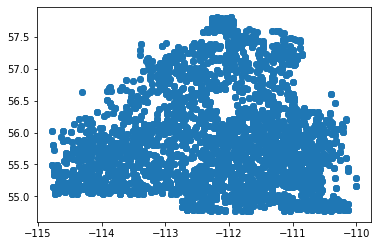

In [14]:
by_wellDF = pd.read_csv('mann_error_map.csv', index_col=[0])
gdf = gpd.GeoDataFrame(by_wellDF, geometry=gpd.points_from_xy(by_wellDF.Longitude, by_wellDF.Latitude))
gdf.crs = {'init':'EPSG:4324'}
gdf.plot()

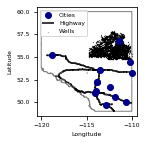

In [15]:
fig, ax = plt.subplots(1,1, figsize=(2,2))
cities.plot(color='darkblue', ax=ax, label='Cities', zorder=4)
state.plot(edgecolor='gray',color='None', ax=ax, zorder=3)
highway.plot(color='black', ax=ax, label='Highway', zorder=3)
gdf.plot(color='k', ax=ax, label='Wells', markersize=0.0125, zorder=2)
plt.ylim(48.5, 60.5)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.xlabel('Longitude', fontsize=6)
plt.ylabel('Latitude', fontsize=6)
plt.legend(fontsize=6)
#plt.savefig('mann_basemap.svg')